## Scenario A - Binary Classifier

### Part 1 - Import de todas as bibliotecas necessárias 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from tabulate import tabulate
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


### Part 2 - Leitura do local dataframe + informações básicas

In [3]:
df = pd.read_csv('RTA Dataset.csv')
pd.set_option('display.max_columns', None)

# vários df's para as diferentes experiências
df_1 = df.copy()
df_2 = df.copy()
df_3 = df.copy()
df_4 = df.copy()

In [4]:
# descrever categorical columns
df.describe(include = 'object')

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
count,12316,12316,12316,12316,11575,11737,11487,11366,11834,8388,7889,12077,11931,12174,11429,12144,12316,12316,12316,12161,12008,12316,12316,12316,12316,9118,9681,12316,12316,12316
unique,1074,7,5,3,7,4,7,17,4,6,3,14,7,9,8,5,4,4,9,10,13,4,3,6,4,7,5,9,20,3
top,15:30:00,Friday,18-30,Male,Junior high school,Employee,5-10yr,Automobile,Owner,Unknown,No defect,Other,Two-way (divided with broken lines road marking),Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,Going straight,Driver or rider,Male,na,3,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
freq,120,2041,4271,11437,7619,9627,3363,3205,10459,2883,7777,3819,4411,10459,4543,11296,9340,8798,10063,8774,8158,4944,5253,4443,7076,5903,9608,11390,2263,10415


In [5]:
unique_values = {}

for col in df.columns:
    value_counts = df[col].value_counts(normalize=True)
    unique_values[col] = [f"{value}: {count*100:.2f}%" for value, count in zip(value_counts.index, value_counts.values)]

print(tabulate(unique_values, headers = 'keys', tablefmt = 'orgtbl'))


| Time            | Day_of_week       | Age_band_of_driver   | Sex_of_driver   | Educational_level          | Vehicle_driver_relation   | Driving_experience   | Type_of_vehicle             | Owner_of_vehicle    | Service_year_of_vehicle   | Defect_of_vehicle   | Area_accident_occured                  | Lanes_or_Medians                                         | Road_allignment                                      | Types_of_Junction   | Road_surface_type                       | Road_surface_conditions     | Light_conditions               | Weather_conditions       | Type_of_collision                              | Number_of_vehicles_involved   | Number_of_casualties   | Vehicle_movement           | Casualty_class          | Sex_of_casualty   | Age_band_of_casualty   | Casualty_severity   | Work_of_casuality     | Fitness_of_casuality   | Pedestrian_movement                                                                                                                          | Cause_of

In [6]:
df.isnull().sum()   #verificar quantas colunas têm valores nulos

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

### Part 3 - pre processing + divisão por experiências

Antes de repartir em experiências, vamos analisar o que significam algumas colunas que aparentam não ser tão importantes para a nossa análise, eliminando-as de qualquer experiência

In [7]:
type_of_vehicle = df['Type_of_vehicle'].value_counts()    #ELIMINAR COM CERTEZA -> irrelevante
print(type_of_vehicle, "\n\n")

owner_of_vehicle = df['Owner_of_vehicle'].value_counts()  #ELIMINAR COM CERTEZA -> irrelevante
print(owner_of_vehicle, "\n\n")

service_year_of_vehicle = df['Service_year_of_vehicle'].value_counts()    #ELIMINAR COM CERTEZA -> muitos nans
print(service_year_of_vehicle, "\n\n")

defect_of_vehicle = df['Defect_of_vehicle'].value_counts()  #tem 7777 "no defect"
print(defect_of_vehicle, "\n\n")    #ELIMINAR -> DADOS CONFUSOS

area_accident_occured = df['Area_accident_occured'].value_counts() #ELIMINAR -> IRRELEVANTE
print(area_accident_occured, "\n\n")

road_allignment = df['Road_allignment'].value_counts()  #ELIMINAR -> muitos dados iguais -> +80%  
print(road_allignment, "\n\n")

pedestrian_movement = df['Pedestrian_movement'].value_counts()  #ELIMINAR -> dados sem sentido
print(pedestrian_movement, "\n\n")

fitness_of_casuality = df['Fitness_of_casuality'].value_counts()  #ELIMINAR -> faltam dados e muitos iguais
print(fitness_of_casuality, "\n\n")

work_of_causalty = df['Work_of_casuality'].value_counts()
print(work_of_causalty, "\n\n")

casualty_class = df['Casualty_class'].value_counts()  #ELIMINAR -> ver matriz de correlação
print(casualty_class, "\n\n")

Type_of_vehicle
Automobile              3205
Lorry (41?100Q)         2186
Other                   1208
Pick up upto 10Q         811
Public (12 seats)        711
Stationwagen             687
Lorry (11?40Q)           541
Public (13?45 seats)     532
Public (> 45 seats)      404
Long lorry               383
Taxi                     265
Motorcycle               177
Special vehicle           84
Ridden horse              76
Turbo                     46
Bajaj                     29
Bicycle                   21
Name: count, dtype: int64 


Owner_of_vehicle
Owner           10459
Governmental     1041
Organization      312
Other              22
Name: count, dtype: int64 


Service_year_of_vehicle
Unknown       2883
2-5yrs        1792
Above 10yr    1324
5-10yrs       1280
1-2yr          827
Below 1yr      282
Name: count, dtype: int64 


Defect_of_vehicle
No defect    7777
7              76
5              36
Name: count, dtype: int64 


Area_accident_occured
Other                              381

Após a análise, eliminamos as colunas que afetam pouco a nossa saída, que, como sabemos, é a última coluna: "Gravidade do Acidente"

In [8]:
colunas_a_eliminar = ['Type_of_vehicle', 'Owner_of_vehicle', 'Defect_of_vehicle', 'Area_accident_occured',
                        'Road_allignment', 'Pedestrian_movement', 'Fitness_of_casuality', 'Work_of_casuality']

df.drop(colunas_a_eliminar, axis = 1, inplace = True)

Agora, para uma melhor compreensão da tabela, vamos renomear as colunas

In [9]:
#time, day_of_week, age_band_of_driver, sex_of_driver, educational_level, vehicle_driver_relation, driving_experience
#type_of_vehicle, owner_of_vehicle, service_year_of_vehicle, defect_of_vehicle, area_accident_occured
#lanes_or_medians, road_allignment, types_of_junction, road_surface_type, road_surface_conditions, ligh_conditions
#weather_conditions, type_of_collision, number_of_vehicles_involved, number_of_casualties, vehicle_movement
#casualty_class, sex_of_casualty, age_band_of_casualty, casualty_severity, work_of_casualty, fitness_of_casualty
#pedestrian_movement, cause_of_accident, accident_severity

colunas_renomeadas = ['Período', 'Dia de Semana', 'Faixa Etária', 'Género', 'Nível de Educação', 'Relação com o Veículo', 
                    'Experiência de Condução', 'Idade do Veículo', 'Situação de Faixa', 'Tipo de Cruzamento',
                    'Tipo de Estrada', 'Condições do Piso', 'Condições de Visibilidade',
                    'Condições Meteorológicas', 'Tipo de Colisão', 'N.º Veículos Envolvidos',
                    'Número de Vítimas', 'Movimento do Veículo', 'Tipo de Vítima','Género da Vítima',
                    'Faixa Etária da Vítima', 'Gravidade da Vítima',
                    'Causa do Acidente', 'Gravidade do Acidente']

df.columns = colunas_renomeadas
df.head()

,Período,Dia de Semana,Faixa Etária,Género,Nível de Educação,Relação com o Veículo,Experiência de Condução,Idade do Veículo,Situação de Faixa,Tipo de Cruzamento,Tipo de Estrada,Condições do Piso,Condições de Visibilidade,Condições Meteorológicas,Tipo de Colisão,N.º Veículos Envolvidos,Número de Vítimas,Movimento do Veículo,Tipo de Vítima,Género da Vítima,Faixa Etária da Vítima,Gravidade da Vítima,Causa do Acidente,Gravidade do Acidente
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Above 10yr,NaN,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,na,na,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,5-10yrs,Undivided Two way,No junction,Asphalt roads,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,NaN,other,No junction,Asphalt roads,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,Male,31-50,3,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,NaN,other,Y Shape,Earth roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,Female,18-30,3,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,5-10yrs,other,Y Shape,Asphalt roads,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,na,na,Overtaking,Slight Injury


Vamos agora perceber quantos valores nulos existem e ainda realizar a substituição desses mesmos pela moda da coluna.

Neste passo, fomos apenar substituir os valores nulos cujas colunas tinham menos de 1000 valores "NaN", uma vez que afeta pouco a proporção dos valores, servindo de base a todas as experiências

In [10]:
df.replace('na', pd.NA, inplace=True) # substituir "na" por um valor realmente nulo
df.isnull().sum()

Período                         0
Dia de Semana                   0
Faixa Etária                    0
Género                          0
Nível de Educação             741
Relação com o Veículo         579
Experiência de Condução       829
Idade do Veículo             3928
Situação de Faixa             385
Tipo de Cruzamento            887
Tipo de Estrada               172
Condições do Piso               0
Condições de Visibilidade       0
Condições Meteorológicas        0
Tipo de Colisão               155
N.º Veículos Envolvidos         0
Número de Vítimas               0
Movimento do Veículo          308
Tipo de Vítima               4443
Género da Vítima             4443
Faixa Etária da Vítima       4443
Gravidade da Vítima          4443
Causa do Acidente               0
Gravidade do Acidente           0
dtype: int64

In [11]:
df['Nível de Educação'] = df['Nível de Educação'].fillna(df['Nível de Educação'].mode()[0])
df['Relação com o Veículo'] = df['Relação com o Veículo'].fillna(df['Relação com o Veículo'].mode()[0])
df['Experiência de Condução'] = df['Experiência de Condução'].fillna(df['Experiência de Condução'].mode()[0])
df['Situação de Faixa'] = df['Situação de Faixa'].fillna(df['Situação de Faixa'].mode()[0])
df['Tipo de Cruzamento'] = df['Tipo de Cruzamento'].fillna(df['Tipo de Cruzamento'].mode()[0])
df['Tipo de Estrada'] = df['Tipo de Estrada'].fillna(df['Tipo de Estrada'].mode()[0])
df['Tipo de Colisão'] = df['Tipo de Colisão'].fillna(df['Tipo de Colisão'].mode()[0])
df['Movimento do Veículo'] = df['Movimento do Veículo'].fillna(df['Movimento do Veículo'].mode()[0])

In [12]:
df.isnull().sum()

Período                         0
Dia de Semana                   0
Faixa Etária                    0
Género                          0
Nível de Educação               0
Relação com o Veículo           0
Experiência de Condução         0
Idade do Veículo             3928
Situação de Faixa               0
Tipo de Cruzamento              0
Tipo de Estrada                 0
Condições do Piso               0
Condições de Visibilidade       0
Condições Meteorológicas        0
Tipo de Colisão                 0
N.º Veículos Envolvidos         0
Número de Vítimas               0
Movimento do Veículo            0
Tipo de Vítima               4443
Género da Vítima             4443
Faixa Etária da Vítima       4443
Gravidade da Vítima          4443
Causa do Acidente               0
Gravidade do Acidente           0
dtype: int64

In [13]:
unique_values = {}

for col in df.columns:
    if col != 'Período':
        value_counts = df[col].value_counts(normalize=True)
        unique_values[col] = [f"{value}: {count*100:.2f}%" for value, count in zip(value_counts.index, value_counts.values)]

print(tabulate(unique_values, headers = 'keys', tablefmt = 'orgtbl'))

| Dia de Semana     | Faixa Etária    | Género         | Nível de Educação          | Relação com o Veículo   | Experiência de Condução   | Idade do Veículo   | Situação de Faixa                                        | Tipo de Cruzamento   | Tipo de Estrada                         | Condições do Piso           | Condições de Visibilidade      | Condições Meteorológicas   | Tipo de Colisão                                | N.º Veículos Envolvidos   | Número de Vítimas   | Movimento do Veículo       | Tipo de Vítima          | Género da Vítima   | Faixa Etária da Vítima   | Gravidade da Vítima   | Causa do Acidente                           | Gravidade do Acidente   |
|-------------------+-----------------+----------------+----------------------------+-------------------------+---------------------------+--------------------+----------------------------------------------------------+----------------------+-----------------------------------------+-----------------------------+-----------

#### Binary target + mapping ordenado

In [14]:
def categorizar_periodo(time):
    hour = time.hour
    if hour >= 0 and hour < 7:
        return "Dawn"
    elif hour >= 7 and hour < 12:
        return "Morning"
    elif hour >= 12 and hour < 17:
        return "Afternoon"
    elif hour >= 17 and hour < 20:
        return "Dusk"
    elif hour >= 20 and hour <= 24:
        return "Night"

In [15]:
faixa_etaria_mapping = {'18-30': 2, '31-50': 3, 'Over 51': 4, 'Unknown': 0, 'Under 18': 1}
genero_mapping = {'Male': 1, 'Female': 2, 'Unknown': 0}
nivel_educacao_mapping = {'Junior high school': 5, 'Elementary school': 4, 'High school': 5, 'Above high school': 6,
                            'Writing & reading': 3, 'Unknown': 0, 'Illiterate': 1}
relacao_com_veiculo_mapping = {'Employee': 3, 'Owner': 2, 'Other': 1, 'Unknown': 0}
experiencia_conducao_mapping = {'5-10yr': 5, '2-5yr': 4, 'Above 10yr': 6, '1-2yr': 3, 'Below 1yr': 2, 'No Licence': 1, 'unknown': 0}
gravidade_acidente_mapping = {'Slight Injury': 0, 'Serious Injury': 1, 'Fatal injury': 1}

df['Período'] = pd.to_datetime(df['Período'], format = '%H:%M:%S')
df["Período"] = df["Período"].map(categorizar_periodo)

periodo_mapping = {'Dawn': 0, 'Morning': 1, 'Afternoon': 2, 'Dusk': 3, 'Night': 4}

df['Faixa Etária'] = df['Faixa Etária'].map(faixa_etaria_mapping)
df['Género'] = df['Género'].map(genero_mapping)
df['Nível de Educação'] = df['Nível de Educação'].map(nivel_educacao_mapping)
df['Relação com o Veículo'] = df['Relação com o Veículo'].map(relacao_com_veiculo_mapping)
df['Experiência de Condução'] = df['Experiência de Condução'].map(experiencia_conducao_mapping)
df['Gravidade do Acidente'] = df['Gravidade do Acidente'].map(gravidade_acidente_mapping)
df['Período'] = df['Período'].map(periodo_mapping)

In [16]:
columns_to_encode = ['Situação de Faixa', 'Tipo de Cruzamento', 'Tipo de Estrada', 
                    'Condições do Piso', 'Condições de Visibilidade', 
                    'Condições Meteorológicas', 'Tipo de Colisão', 
                    'Movimento do Veículo', 'Causa do Acidente']

# fazer enconder das que não se podem ordenar
label_encoder = LabelEncoder()

for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

In [17]:
unique_values = {}

for col in df.columns:
    value_counts = df[col].value_counts(normalize=True)
    unique_values[col] = [f"{value}: {count*100:.2f}%" for value, count in zip(value_counts.index, value_counts.values)]

print(tabulate(unique_values, headers = 'keys', tablefmt = 'orgtbl'))

| Período   | Dia de Semana     | Faixa Etária   | Género    | Nível de Educação   | Relação com o Veículo   | Experiência de Condução   | Idade do Veículo   | Situação de Faixa   | Tipo de Cruzamento   | Tipo de Estrada   | Condições do Piso   | Condições de Visibilidade   | Condições Meteorológicas   | Tipo de Colisão   | N.º Veículos Envolvidos   | Número de Vítimas   | Movimento do Veículo   | Tipo de Vítima          | Género da Vítima   | Faixa Etária da Vítima   | Gravidade da Vítima   | Causa do Acidente   | Gravidade do Acidente   |
|-----------+-------------------+----------------+-----------+---------------------+-------------------------+---------------------------+--------------------+---------------------+----------------------+-------------------+---------------------+-----------------------------+----------------------------+-------------------+---------------------------+---------------------+------------------------+-------------------------+--------------------+------

In [18]:
df_1 = df.copy()
df_2 = df.copy()
df_3 = df.copy()
df_4 = df.copy()

#### Divisão por experiências:

 *  exp 1 - distribuir a proporção dos valores nulos (>4000) pelos restantes valores, mantendo a proporção
 *  exp 2 - eliminar colunas com valores nulos > 3500
 *  exp 3 - substituir valores nulos por valores em que a coluna da gravidade é a mesma (tendo em conta a sua moda)
 *  exp 4 - aplicar método do KNN às colunas com valores nulos

#### Part 3.1 - distribuir a proporção dos valores nulos

In [19]:
# definimos as colunas que queremos alterar
colunas_a_substituir = ['Idade do Veículo', 'Tipo de Vítima', 'Género da Vítima', 'Faixa Etária da Vítima', 'Gravidade da Vítima']

for coluna in colunas_a_substituir:

    no_valores_nulos = df_1[coluna].isnull().sum()

    # proporção de valores não nulos para cada categoria
    proporcoes_categoria = df_1[coluna].value_counts(normalize = True)

    # calcular o número de valores nulos a serem distribuídos para cada categoria
    distribuicao_nulos = (proporcoes_categoria * no_valores_nulos).round().astype(int)

    # neste caso, damos assign a cada valor nulo de forma RANDOM
    indices_nulo = df_1[df_1[coluna].isnull()].index
    for category, count in distribuicao_nulos.items():
        sample_indices = np.random.choice(indices_nulo, size = count, replace = False)
        df_1.loc[sample_indices, coluna] = category

    # preencher algum valor nulo que falte, RANDOM
    remaining_null_indices = df_1[df_1[coluna].isnull()].index
    remaining_categories = list(proporcoes_categoria.index)
    for index in remaining_null_indices:
        df_1.at[index, coluna] = np.random.choice(remaining_categories)

In [20]:
df_1.isnull().sum()

Período                      0
Dia de Semana                0
Faixa Etária                 0
Género                       0
Nível de Educação            0
Relação com o Veículo        0
Experiência de Condução      0
Idade do Veículo             0
Situação de Faixa            0
Tipo de Cruzamento           0
Tipo de Estrada              0
Condições do Piso            0
Condições de Visibilidade    0
Condições Meteorológicas     0
Tipo de Colisão              0
N.º Veículos Envolvidos      0
Número de Vítimas            0
Movimento do Veículo         0
Tipo de Vítima               0
Género da Vítima             0
Faixa Etária da Vítima       0
Gravidade da Vítima          0
Causa do Acidente            0
Gravidade do Acidente        0
dtype: int64

In [21]:
percentage_values = {}
for column in df_1.columns:
    counts = df_1[column].value_counts(normalize = True, dropna = False) * 100
    percentage_values[column] = counts

for column, percentages in percentage_values.items():
    print(percentages)
    print()

Período
2    31.641767
1    24.537187
3    23.481650
4    13.121143
0     7.218253
Name: proportion, dtype: float64

Dia de Semana
Friday       16.571939
Thursday     15.029230
Wednesday    14.939916
Tuesday      14.371549
Monday       13.648912
Saturday     13.527119
Sunday       11.911335
Name: proportion, dtype: float64

Faixa Etária
2    34.678467
3    33.184475
4    12.869438
0    12.569016
1     6.698603
Name: proportion, dtype: float64

Género
1    92.862943
2     5.691783
0     1.445274
Name: proportion, dtype: float64

Nível de Educação
5    76.891848
4    17.562520
6     2.939266
3     1.429035
0     0.811952
1     0.365378
Name: proportion, dtype: float64

Relação com o Veículo
3    82.867814
2    16.019812
1     0.998701
0     0.113673
Name: proportion, dtype: float64

Experiência de Condução
5    34.037025
4    21.216304
6    18.366353
3    14.257876
2    10.896395
1     0.958103
0     0.267944
Name: proportion, dtype: float64

Idade do Veículo
Unknown       30.326405
2-5y

#### Part 3.2 - eliminar colunas com valores nulos > 3500

In [22]:
colunas_valores_nulos = ['Idade do Veículo', 'Tipo de Vítima', 'Género da Vítima', 'Faixa Etária da Vítima', 'Gravidade da Vítima']

df_2.drop(colunas_valores_nulos, axis = 1, inplace = True)

In [23]:
df_2.isnull().sum()

Período                      0
Dia de Semana                0
Faixa Etária                 0
Género                       0
Nível de Educação            0
Relação com o Veículo        0
Experiência de Condução      0
Situação de Faixa            0
Tipo de Cruzamento           0
Tipo de Estrada              0
Condições do Piso            0
Condições de Visibilidade    0
Condições Meteorológicas     0
Tipo de Colisão              0
N.º Veículos Envolvidos      0
Número de Vítimas            0
Movimento do Veículo         0
Causa do Acidente            0
Gravidade do Acidente        0
dtype: int64

#### Part 3.3 - substituir valores nulos por valores em que a coluna da gravidade é a mesma (tendo em conta a sua moda)

In [24]:
# definimos as colunas que queremos alterar
colunas_a_substituir = ['Idade do Veículo', 'Tipo de Vítima', 'Género da Vítima', 'Faixa Etária da Vítima', 'Gravidade da Vítima']

percentage_values = {}
for column in colunas_a_substituir:
    counts = df_3[column].value_counts(normalize = True, dropna = False) * 100
    percentage_values[column] = counts

for column, percentages in percentage_values.items():
    print(percentages)
    print()

Idade do Veículo
NaN           31.893472
Unknown       23.408574
2-5yrs        14.550179
Above 10yr    10.750244
5-10yrs       10.392985
1-2yr          6.714842
Below 1yr      2.289704
Name: proportion, dtype: float64

Tipo de Vítima
Driver or rider    40.142904
<NA>               36.075024
Pedestrian         13.389087
Passenger          10.392985
Name: proportion, dtype: float64

Género da Vítima
Male      42.651835
<NA>      36.075024
Female    21.273141
Name: proportion, dtype: float64

Faixa Etária da Vítima
<NA>        36.075024
18-30       25.535888
31-50       19.933420
Under 18     8.403703
Over 51      8.070802
5            1.981163
Name: proportion, dtype: float64

Gravidade da Vítima
3       57.453719
<NA>    36.075024
2        6.260149
1        0.211108
Name: proportion, dtype: float64



In [25]:
# Define the target column
target_column = 'Gravidade do Acidente'

# Iterate over each column with null values
for column in colunas_a_substituir:
    
    # Calculate the proportions of each value in the column for each category in the target column
    proportions = df_3.groupby(target_column)[column].value_counts(normalize=True)
    
    # For each null value in the column, replace it based on the proportions
    for index, row in df_3[df_3[column].isnull()].iterrows():
        
        # Get the proportions for the target value of this row
        target_value = row[target_column]
        target_proportions = proportions[target_value]
        
        # Sample from the proportions to replace the null value
        new_value = target_proportions.sample(weights=target_proportions).index[0]
        
        # Replace the null value
        df_3.at[index, column] = new_value

In [ ]:
df_3.isnull().sum()

Período                      0
Dia de Semana                0
Faixa Etária                 0
Género                       0
Nível de Educação            0
Relação com o Veículo        0
Experiência de Condução      0
Idade do Veículo             0
Situação de Faixa            0
Tipo de Cruzamento           0
Tipo de Estrada              0
Condições do Piso            0
Condições de Visibilidade    0
Condições Meteorológicas     0
Tipo de Colisão              0
N.º Veículos Envolvidos      0
Número de Vítimas            0
Movimento do Veículo         0
Tipo de Vítima               0
Género da Vítima             0
Faixa Etária da Vítima       0
Gravidade da Vítima          0
Causa do Acidente            0
Gravidade do Acidente        0
dtype: int64

In [ ]:
percentage_values = {}
for column in colunas_a_substituir:
    counts = df_3[column].value_counts(normalize = True, dropna = False) * 100
    percentage_values[column] = counts

for column, percentages in percentage_values.items():
    print(percentages)
    print()

Idade do Veículo
Unknown       34.459240
2-5yrs        21.191945
Above 10yr    15.995453
5-10yrs       15.370250
1-2yr          9.637869
Below 1yr      3.345242
Name: proportion, dtype: float64

Tipo de Vítima
Driver or rider    62.950633
Pedestrian         20.794089
Passenger          16.255278
Name: proportion, dtype: float64

Género da Vítima
Male      66.961676
Female    33.038324
Name: proportion, dtype: float64

Faixa Etária da Vítima
18-30       40.053589
31-50       31.268269
Under 18    13.186099
Over 51     12.463462
5            3.028581
Name: proportion, dtype: float64

Gravidade da Vítima
3    89.956155
2     9.686587
1     0.357259
Name: proportion, dtype: float64



#### Part 3.4 - aplicar método do KNN às colunas com valores nulos

In [ ]:
imputer = KNNImputer()

# Get the columns with null values
colunas_a_substituir = df_4.columns[df_4.isnull().any()]

# Iterate over each column with null values
for column in colunas_a_substituir:
    # If the column is categorical, encode it using one-hot encoding or ordinal encoding
    if df_4[column].dtype == 'object':
        # Convert 'NAType' to NaN
        df_4[column] = df_4[column].replace('NAType', np.nan)
        # Handle missing values with a placeholder
        df_4[column] = df_4[column].fillna('missing')
        
        # Apply ordinal encoding
        encoder = OrdinalEncoder()
        encoded_values = encoder.fit_transform(df_4[[column]])
        encoded_df = pd.DataFrame(encoded_values, columns=[column], index=df_4.index)
        # Drop the original categorical column and concatenate the encoded columns
        df_4 = pd.concat([df_4.drop(column, axis=1), encoded_df], axis=1)
    else:
        # Extract the column data
        X = df_4.dropna(subset=[column], axis=0).drop(colunas_a_substituir, axis=1)
        y = df_4.dropna(subset=[column], axis=0)[column]
        X_with_null = df_4[df_4[column].isnull()].drop(colunas_a_substituir, axis=1)
        
        # Apply KNN imputation
        imputer.fit(X, y)
        imputed_values = imputer.transform(X_with_null)
        
        # Update the dataframe with imputed values
        df_4.loc[X_with_null.index, column] = imputed_values


In [ ]:
df_4.isnull().sum()

Período                      0
Dia de Semana                0
Faixa Etária                 0
Género                       0
Nível de Educação            0
Relação com o Veículo        0
Experiência de Condução      0
Situação de Faixa            0
Tipo de Cruzamento           0
Tipo de Estrada              0
Condições do Piso            0
Condições de Visibilidade    0
Condições Meteorológicas     0
Tipo de Colisão              0
N.º Veículos Envolvidos      0
Número de Vítimas            0
Movimento do Veículo         0
Causa do Acidente            0
Gravidade do Acidente        0
Idade do Veículo             0
Tipo de Vítima               0
Género da Vítima             0
Faixa Etária da Vítima       0
Gravidade da Vítima          0
dtype: int64

In [ ]:
percentage_values = {}
for column in df_4.columns:
    counts = df_4[column].value_counts(normalize = True, dropna = False) * 100
    percentage_values[column] = counts

for column, percentages in percentage_values.items():
    print(percentages)
    print()

Período
2    31.641767
1    24.537187
3    23.481650
4    13.121143
0     7.218253
Name: proportion, dtype: float64

Dia de Semana
Friday       16.571939
Thursday     15.029230
Wednesday    14.939916
Tuesday      14.371549
Monday       13.648912
Saturday     13.527119
Sunday       11.911335
Name: proportion, dtype: float64

Faixa Etária
2    34.678467
3    33.184475
4    12.869438
0    12.569016
1     6.698603
Name: proportion, dtype: float64

Género
1    92.862943
2     5.691783
0     1.445274
Name: proportion, dtype: float64

Nível de Educação
5    76.891848
4    17.562520
6     2.939266
3     1.429035
0     0.811952
1     0.365378
Name: proportion, dtype: float64

Relação com o Veículo
3    82.867814
2    16.019812
1     0.998701
0     0.113673
Name: proportion, dtype: float64

Experiência de Condução
5    34.037025
4    21.216304
6    18.366353
3    14.257876
2    10.896395
1     0.958103
0     0.267944
Name: proportion, dtype: float64

Situação de Faixa
2    38.941215
4    30.8216

### Part 4 - Fazer matriz de correlação e importância de variáveis

Após o pré-processamento, decidimos ficar com a terceira experiência, pois é a que apresenta melhores resultados, como podemos observar através da matriz de correlação entre as variáveis.

Aplicamos ainda o mapping às colunas anteriormente nulas

In [ ]:
df = df_3.copy()

idade_do_veiculo_mapping = {'Unknown': 0, '2-5yrs': 3, 'Above 10yr': 5, '5-10yrs': 4 , '1-2yr': 2, 'Below 1yr': 1}
tipo_vitima_mapping = {'Driver or rider': 1, 'Pedestrian': 2, 'Passenger': 3}
genero_vitima_mapping = {'Male': 1, 'Female': 0}
faixa_etaria_vitima_mapping = {'18-30': 3, '31-50': 4, 'Under 18': 2, 'Over 51': 5, '5': 1}
dia_de_semana_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday' : 4, 'Friday' : 5, 'Saturday' : 6, 'Sunday' : 7}


df['Idade do Veículo'] = df['Idade do Veículo'].map(idade_do_veiculo_mapping)
df['Tipo de Vítima'] = df['Tipo de Vítima'].map(tipo_vitima_mapping)
df['Género da Vítima'] = df['Género da Vítima'].map(genero_vitima_mapping)
df['Faixa Etária da Vítima'] = df['Faixa Etária da Vítima'].map(faixa_etaria_vitima_mapping)
df['Dia de Semana'] = df['Dia de Semana'].map(dia_de_semana_mapping)

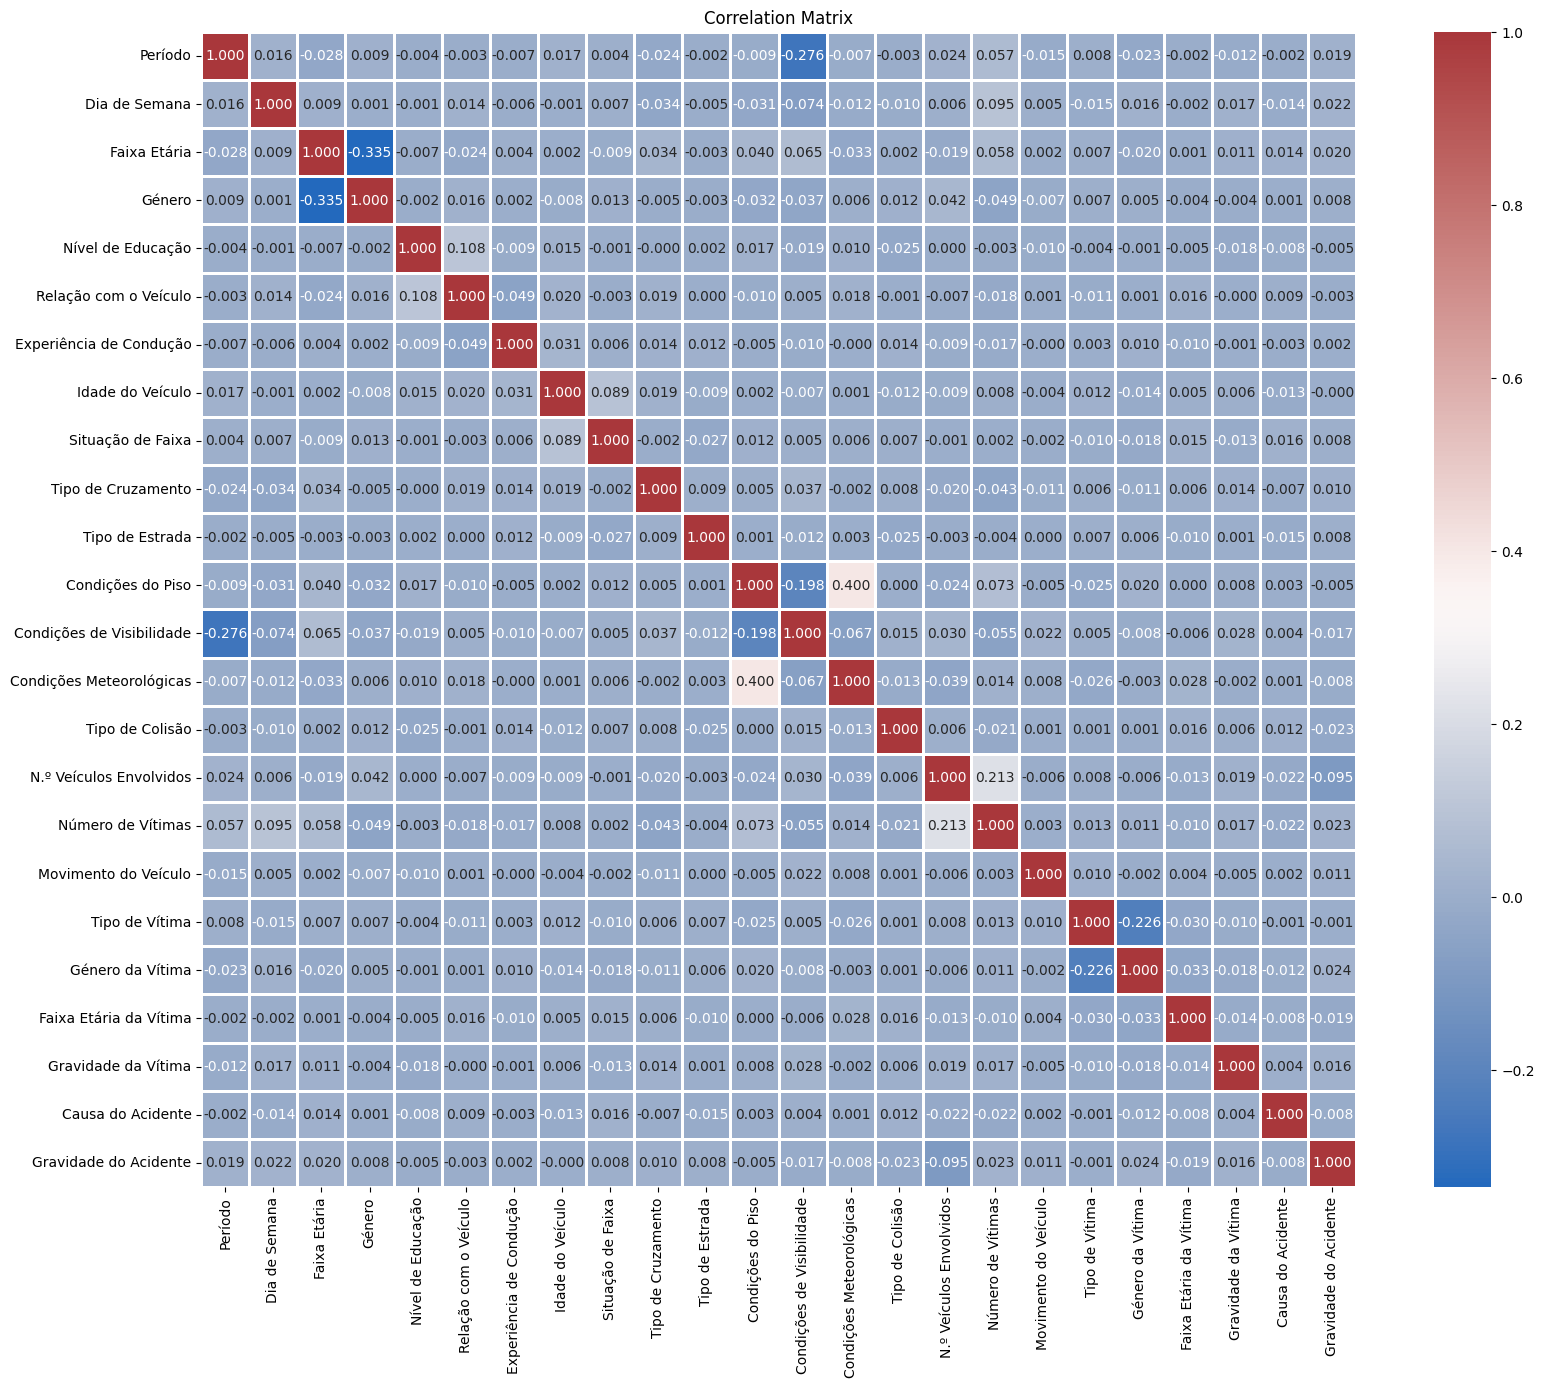

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize = (20, 15))
sns.heatmap(correlation_matrix, annot = True, cmap = 'vlag', fmt = ".3f", linewidths = 1, square=True)
plt.title('Correlation Matrix')
plt.show()

De seguida, analisamos a importância de cada feature para o modelo 

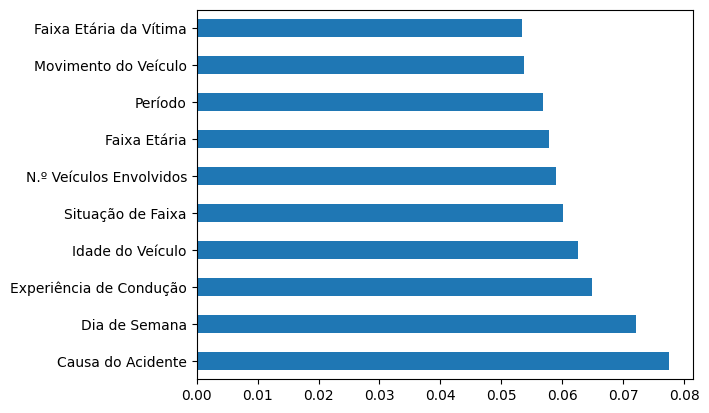

In [ ]:
X = df.iloc[:, :-1].values # todas as features
Y =  df.iloc[:, -1].values # feature target

modelo = ExtraTreesClassifier()
modelo.fit(X, Y)

feature_importances = pd.Series(modelo.feature_importances_, index = df.columns[:-1])
feature_importances.nlargest(10).plot(kind='barh')  # mostrar as 10 features mais importantes

plt.show()

Valores e Proporção da variavél target

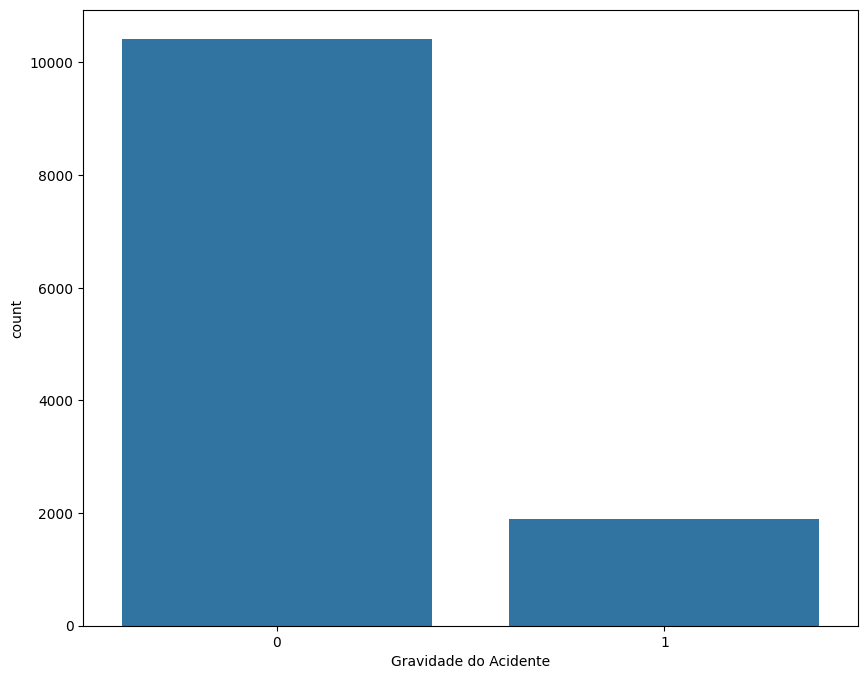

In [ ]:
plt.figure(figsize = (10, 8))
sns.countplot(data = df, x = "Gravidade do Acidente")
plt.show()

Neste ponto, dividimos os dados em sets de treino e de teste, utilizando 30% dos dados para teste e os restantes para teino

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 30)

print("Número de exemplos nos dados de treino: ", X_train.shape[0])
print("Número de exemplos nos dados de teste: ", X_test.shape[0])

Número de exemplos nos dados de treino:  8621
Número de exemplos nos dados de teste:  3695


Primeiro vamos estanderizar as nossas features. Isso é feito para garantir que todas as características tenham a mesma escala, o que pode melhorar o desempenho do algoritmo. 

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Part 5 - Neural Networks


Primeiro fomos à procura dos melhores hiperparâmetros

In [39]:
param_grid = {'hidden_layer_sizes': [(10,10,10), (10,10,10,10), (10,10,10,10,10)],
                'max_iter': [100000, 200000, 300000],
                'tol': [0.0001, 0.001, 0.01]}
grid = GridSearchCV(MLPClassifier(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END hidden_layer_sizes=(10, 10, 10), max_iter=100000, tol=0.0001;, score=0.831 total time=   5.0s
[CV 2/5] END hidden_layer_sizes=(10, 10, 10), max_iter=100000, tol=0.0001;, score=0.830 total time=   6.7s
[CV 3/5] END hidden_layer_sizes=(10, 10, 10), max_iter=100000, tol=0.0001;, score=0.827 total time=   8.0s
[CV 4/5] END hidden_layer_sizes=(10, 10, 10), max_iter=100000, tol=0.0001;, score=0.830 total time=   4.2s
[CV 5/5] END hidden_layer_sizes=(10, 10, 10), max_iter=100000, tol=0.0001;, score=0.831 total time=  10.4s
[CV 1/5] END hidden_layer_sizes=(10, 10, 10), max_iter=100000, tol=0.001;, score=0.843 total time=   0.3s
[CV 2/5] END hidden_layer_sizes=(10, 10, 10), max_iter=100000, tol=0.001;, score=0.844 total time=   0.8s
[CV 3/5] END hidden_layer_sizes=(10, 10, 10), max_iter=100000, tol=0.001;, score=0.844 total time=   0.3s
[CV 4/5] END hidden_layer_sizes=(10, 10, 10), max_iter=100000, tol=0.001;, score=0.84

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV 2/5] END hidden_layer_sizes=(10, 10, 10, 10), max_iter=200000, tol=0.0001;, score=0.843 total time=   2.5s


Ao correr o código acima vemos que os melhores hiperparâmetros são: 

- {'hidden_layer_sizes': (10, 10, 10), 'max_iter': 300000, 'tol': 0.001}

Após a escolha dos melhores hiperparâmetros, decidimos criar uma baseline com 7 experiências: 

- Experiência I: Normal
- Experiência II: 20% de Upsampling
- Experiência III: 60% de Upsampling
- Experiência IV: 60% de DownSampling
- Experiência V: Pipeline de Upsampling e Downsampling
- Experiência VI: Método de SMOTE
- Experiência VII: Método de ADASYN

#### Part 5.1 - Aplicar o método de forma Normal

In [36]:
mlp_1 = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=300000, tol= 0.001, random_state=1)

mlp_1 = mlp_1.fit(X_train, y_train)

y_pred_1 = mlp_1.predict(X_test)
y_train_pred_1 = mlp_1.predict(X_train)

#### Part 5.2 - 20% de Upsampling

In [37]:
oversample_2 = RandomOverSampler(sampling_strategy=0.2, random_state=42)
X_train_resampled_2, y_train_resampled_2 = oversample_2.fit_resample(X_train, y_train)

mlp_2 = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=300000, tol=0.001, random_state=1)
mlp_2.fit(X_train_resampled_2, y_train_resampled_2)

y_pred_2 = mlp_2.predict(X_test)
y_train_pred_2 = mlp_2.predict(X_train)

#### Part 5.3 - 60% de Upsampling

In [38]:
oversample_3 = RandomOverSampler(sampling_strategy=0.6, random_state=42)
X_train_resampled_3, y_train_resampled_3 = oversample_3.fit_resample(X_train, y_train)

mlp_3 = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=300000, tol=0.001, random_state=1)
mlp_3.fit(X_train_resampled_3, y_train_resampled_3)

y_pred_3 = mlp_3.predict(X_test)
y_train_pred_3 = mlp_3.predict(X_train)

#### Part 5.4 - 60% de Downsampling

In [39]:
undersample_4 = RandomUnderSampler(sampling_strategy=0.6, random_state=42) 
X_train_resampled_4, y_train_resampled_4 = undersample_4.fit_resample(X_train, y_train)

mlp_4 = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=300000, tol=0.001, random_state=1)
mlp_4.fit(X_train_resampled_4, y_train_resampled_4)

y_pred_4 = mlp_4.predict(X_test)
y_train_pred_4 = mlp_4.predict(X_train)

#### Part 5.5 - Pipeline de Upsampling de 60% e Downsampling de 60%

In [40]:
pipeline_5 = Pipeline([
            ('over', RandomOverSampler(sampling_strategy=0.6, random_state=42)),
            ('under', RandomUnderSampler(sampling_strategy=0.6, random_state=42) ),
        ])

X_train_resampled_5, y_train_resampled_5 = pipeline_5.fit_resample(X_train, y_train)

mlp_5 = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=300000, tol=0.001, random_state=1)
mlp_5.fit(X_train_resampled_5, y_train_resampled_5)

y_pred_5 = mlp_5.predict(X_test)
y_train_pred_5 = mlp_5.predict(X_train)


#### Part 5.6 - Método de SMOTE (Synthetic Minority Over-sampling Technique)

In [41]:
smote_6 = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_train_resampled_6, y_train_resampled_6 = smote_6.fit_resample(X_train, y_train)

mlp_6 = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=300000, tol=0.001, random_state=1)
mlp_6.fit(X_train_resampled_6, y_train_resampled_6)

y_pred_6 = mlp_6.predict(X_test)
y_train_pred_6 = mlp_6.predict(X_train)


#### Part 5.7 - Método de ADASYN (Adaptive Synthetic Sampling)

In [42]:
adasyn_7 = ADASYN(sampling_strategy='auto', random_state=42)
X_train_resampled_7, y_train_resampled_7 = adasyn_7.fit_resample(X_train, y_train)

mlp_7 = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=300000, tol=0.001, random_state=1)
mlp_7.fit(X_train_resampled_7, y_train_resampled_7)

y_pred_7 = mlp_7.predict(X_test)
y_train_pred_7 = mlp_7.predict(X_train)

Agora vamos observar os diferentes classification reports

In [43]:
# Print dos valores accuracy
y_pred_todos = []
y_pred_todos.extend([y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5, y_pred_6, y_pred_7])

y_train_pred_todos=[]
y_train_pred_todos.extend([y_train_pred_1, y_train_pred_2, y_train_pred_3, y_train_pred_4, y_train_pred_5, y_train_pred_6, y_train_pred_7])

for indice, (y_pred, y_train_pred) in enumerate(zip(y_pred_todos, y_train_pred_todos)):
    print('\n\tClassification_report -', indice + 1, 'Experiência\n')
    print('Train data accuracy: ', accuracy_score(y_true = y_train, y_pred = y_train_pred))
    print('Test data accuracy: ', accuracy_score(y_true = y_test, y_pred = y_pred))
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    print('\n')
    print(classification_report(y_test, y_pred, zero_division = 1))
    
    


	Classification_report - 1 Experiência

Train data accuracy:  0.8437536248695047
Test data accuracy:  0.8500676589986468
Misclassified samples: 554
Accuracy: 0.85


              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3141
           1       1.00      0.00      0.00       554

    accuracy                           0.85      3695
   macro avg       0.93      0.50      0.46      3695
weighted avg       0.87      0.85      0.78      3695


	Classification_report - 2 Experiência

Train data accuracy:  0.8441016123419557
Test data accuracy:  0.8495263870094723
Misclassified samples: 556
Accuracy: 0.85


              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3141
           1       0.25      0.00      0.00       554

    accuracy                           0.85      3695
   macro avg       0.55      0.50      0.46      3695
weighted avg       0.76      0.85      0.78      3695


	Classificati

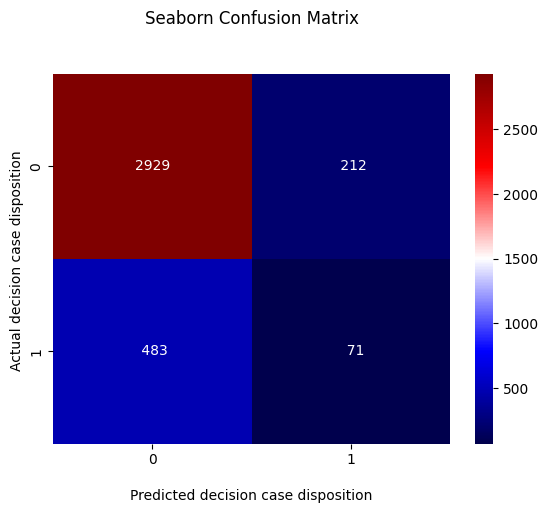

In [44]:
cf_matrix = confusion_matrix(y_test, y_pred_4)

ax = sns.heatmap(cf_matrix, annot = True, cmap = 'seismic', fmt = "4.0f")
ax.set_title('Seaborn Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted decision case disposition')
ax.set_ylabel('Actual decision case disposition ')

plt.show()

### Part 6 - Support Vector Machine

Primeiro fomos à procura dos melhores hiperparâmetros

In [45]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.0001, 0.001, 0.01, 0.1],
                'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.843 total time=   1.3s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.844 total time=   1.5s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.844 total time=   1.5s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.844 total time=   1.6s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.843 total time=   1.5s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.843 total time=   1.7s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.844 total time=   1.8s
[CV 3/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.844 total time=   1.6s
[CV 4/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.844 total time=   1.8s
[CV 5/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.843 total time=   1.8s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.843 total time=   3.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [36]:
param_grid = {'C': [0.1, 1, 10],
                'gamma': [0.0001, 0.001, 0.01, 0.1],
                'kernel': ['linear']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.843 total time=   0.6s
[CV 2/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.844 total time=   0.6s
[CV 3/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.844 total time=   0.5s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.844 total time=   0.5s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.843 total time=   0.7s
[CV 1/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.843 total time=   0.5s
[CV 2/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.844 total time=   0.7s
[CV 3/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.844 total time=   0.6s
[CV 4/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.844 total time=   0.7s
[CV 5/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.843 total time=   0.6s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.843 total time=   0.7s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear;

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Ao correr os código acima vemos que os melhores hiperparâmetros são: 
- {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
- {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}

Após a escolha dos melhores hiperparâmetros, decidimos criar uma baseline com x experiências: 

- Experiência I: Normal
- Experiência II: 40% de Upsampling
- Experiência III: 70% de Upsampling
- Experiência IV: 60% de DownSampling
- Experiência V: Pipeline de Upsampling e Downsampling

### Part 6.1 - Utilizar os primeiros hiperparâmetros

#### Part 6.1.1 - Aplicar o método de forma normal

In [36]:
svc_1 = SVC(C=1, gamma=0.1, kernel='rbf')
svc_1.fit(X_train, y_train)

y_pred_1 = svc_1.predict(X_test)
y_train_pred_1 = svc_1.predict(X_train)

#### Part 6.1.2 - 40 % de UpSampling

In [39]:
oversample_2 = RandomOverSampler(sampling_strategy=0.4, random_state=42)
X_train_resampled_2, y_train_resampled_2 = oversample_2.fit_resample(X_train, y_train)

svc_2 = SVC(C=1, gamma=0.1, kernel='rbf')
svc_2.fit(X_train_resampled_2, y_train_resampled_2)

y_pred_2 = svc_2.predict(X_test)
y_train_pred_2 = svc_2.predict(X_train)

#### Part 6.1.3 - 70% de UpSampling

In [40]:
oversample_3 = RandomOverSampler(sampling_strategy=0.7, random_state=42)
X_train_resampled_3, y_train_resampled_3 = oversample_3.fit_resample(X_train, y_train)

svc_3 = SVC(C=1, gamma=0.1, kernel='rbf')
svc_3.fit(X_train_resampled_3, y_train_resampled_3)

y_pred_3 = svc_3.predict(X_test)
y_train_pred_3 = svc_3.predict(X_train)

#### Part 6.1.4 - 60% de DownSampling

In [42]:
undersample_4 = RandomUnderSampler(sampling_strategy=0.6, random_state=42) 
X_train_resampled_4, y_train_resampled_4 = undersample_4.fit_resample(X_train, y_train)

svc_4 = SVC(C=1, gamma=0.1, kernel='rbf')
svc_4.fit(X_train_resampled_4, y_train_resampled_4)

y_pred_4 = svc_4.predict(X_test)
y_train_pred_4 = svc_4.predict(X_train)

#### Part 6.1.5 - 60% de UpSampling e 60% de DownSampling

In [44]:
pipeline_5 = Pipeline([
            ('over', RandomOverSampler(sampling_strategy=0.6, random_state=42)),
            ('under', RandomUnderSampler(sampling_strategy=0.6, random_state=42) ),
        ])

X_train_resampled_5, y_train_resampled_5 = pipeline_5.fit_resample(X_train, y_train)

svc_5 = SVC(C=1, gamma=0.1, kernel='rbf')
svc_5.fit(X_train_resampled_5, y_train_resampled_5)

y_pred_5 = svc_5.predict(X_test)
y_train_pred_5 = svc_5.predict(X_train)

Agora vamos observar os diferentes classification reports

In [46]:
# Print dos valores accuracy
y_pred_todos = []
y_pred_todos.extend([y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_pred_5])

y_train_pred_todos=[]
y_train_pred_todos.extend([y_train_pred_1, y_train_pred_2, y_train_pred_3, y_train_pred_4, y_train_pred_5])

for indice, (y_pred, y_train_pred) in enumerate(zip(y_pred_todos, y_train_pred_todos)):
    print('\n\tClassification_report -', indice + 1, 'Experiência\n')
    print('Train data accuracy: ', accuracy_score(y_true = y_train, y_pred = y_train_pred))
    print('Test data accuracy: ', accuracy_score(y_true = y_test, y_pred = y_pred))
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    print('\n')
    print(classification_report(y_test, y_pred, zero_division = 1))


	Classification_report - 1 Experiência

Train data accuracy:  0.8751884932142443
Test data accuracy:  0.8508795669824086
Misclassified samples: 551
Accuracy: 0.85


              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3141
           1       0.71      0.01      0.02       554

    accuracy                           0.85      3695
   macro avg       0.78      0.50      0.47      3695
weighted avg       0.83      0.85      0.78      3695


	Classification_report - 2 Experiência

Train data accuracy:  0.9358543092448672
Test data accuracy:  0.8414073071718539
Misclassified samples: 586
Accuracy: 0.84


              precision    recall  f1-score   support

           0       0.86      0.98      0.91      3141
           1       0.35      0.07      0.11       554

    accuracy                           0.84      3695
   macro avg       0.60      0.52      0.51      3695
weighted avg       0.78      0.84      0.79      3695


	Classificati

Após analise dos classification reports, concluimos que o que obtem melhores resultados é a experiência 5

In [1]:
cf_matrix = confusion_matrix(y_test, y_pred_5)

ax = sns.heatmap(cf_matrix, annot = True, cmap = 'seismic', fmt = "4.0f")
ax.set_title('Seaborn Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted decision case disposition')
ax.set_ylabel('Actual decision case disposition ')

plt.show()

NameError: name 'confusion_matrix' is not defined